<a href="https://colab.research.google.com/github/Tlen33/Fully-Connected-and-Recurrent-Neural-Networks-for-Time-Series-Forecasting/blob/main/%D0%92%D1%80%D0%B5%D0%BC%D0%B5%D0%BD%D0%BD%D1%8B%D0%B5_%D1%80%D1%8F%D0%B4%D1%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Импорт библиотек

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, LSTM
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_data16 = pd.read_csv('/content/drive/MyDrive/Базы/акции лукойл/16_17.csv', sep=';')
base_data18 = pd.read_csv('/content/drive/MyDrive/Базы/акции лукойл/18_19.csv', sep=';')
data16_17 = base_data16.iloc[:,2:]
data18_19 = base_data18.iloc[:,2:]

In [ ]:
data16_17.shape[0]

263925

In [ ]:
data16_17.head()

,OPEN,MAX,MIN,CLOSE,VOLUME
0,2351.0,2355.8,2350.0,2350.0,2547
1,2352.9,2355.7,2350.0,2355.7,195
2,2355.6,2356.0,2351.4,2354.1,257
3,2354.5,2355.0,2351.2,2353.7,763
4,2353.1,2353.9,2353.1,2353.6,231


In [ ]:
# Объединяем базы из двух файлов
data = data16_17.copy()                 # Создаем копию первой базы
data = pd.concat([data16_17,data18_19]) # Присоединяем к ней вторую базу
data = np.array(data)                   # Превращаем в numpy массив

In [ ]:
# Сравниваем размеры
print(len(data16_17)) # Выводим размер первой базы
print(len(data18_19)) # Выводим размер второй базы
print(len(data))      # Выводим размер суммарной базы

263925
217947
481872


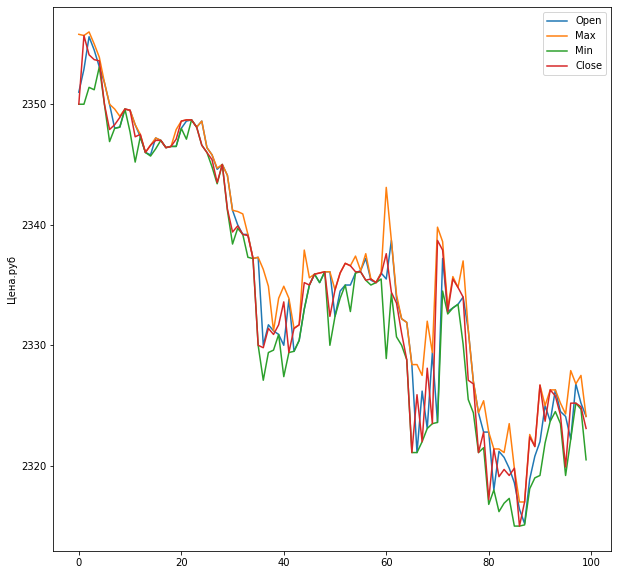

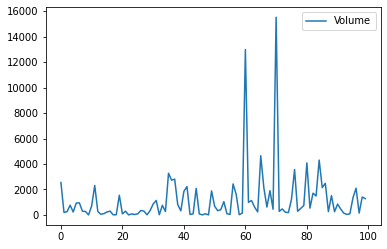

In [ ]:
#Отображаем исходные от точки start и длиной step
start = 0            #С какой точки начинаем
step = 100 #data.shape[0] #Сколько точек отрисуем

#Заполняем текстовые названия каналов данных
chanelNames = ['Open', 'Max', 'Min', 'Close', 'Volume']

#Рисуем все графики данных
#Четыре основных канала - open, max, min, close

plt.figure(figsize=(10, 10))
for i in range(4):
  #Отрисовываем часть данных
  #От начальной точки до начальной точки + размер шага отрисовки
  plt.plot(data[start:start+step,i], 
          label=chanelNames[i])
plt.ylabel('Цена.руб')
plt.legend()
plt.show()

#Канал volume
plt.plot(data[start:start+step,4], label="Volume")
plt.legend()
plt.show()

In [ ]:
#Формируем параметры загрузки данных
xLen = 300                       #Анализируем по 300 прошедшим точкам 
valLen = 30000                   #Используем 30000 записей для проверки
stepsForward = 10
trainLen = data.shape[0]-valLen #Размер тренировочной выборки

#Делим данные на тренировочную и тестовую выборки 
xTrain,xTest = data[:trainLen-stepsForward], data[trainLen+xLen+2:-stepsForward+1]

#Масштабируем данные (отдельно для X и Y), чтобы их легче было скормить сетке
xScaler = StandardScaler()
xScaler.fit(xTrain)
xTrain = xScaler.transform(xTrain)
xTest = xScaler.transform(xTest)

#Для подготовки yTrain на 10 шагов вперед необходимо создать дополнительный датасет
yTrain = np.array([data[:trainLen,3][i:i+stepsForward] for i in range(trainLen-stepsForward)])
yTest = np.array([data[trainLen+xLen+2:,3][i:i+stepsForward] for i in range(valLen-xLen-stepsForward-1)])
yScaler = StandardScaler()
yScaler.fit(yTrain)
yTrain = yScaler.transform(yTrain)
yTest = yScaler.transform(yTest)

#Создаем генератор для обучения
trainDataGen = TimeseriesGenerator(xTrain, yTrain,           #В качестве параметров наши выборки
                               length=xLen, sampling_rate=1, #Для каждой точки
                               batch_size=20)                #Размер batch, который будем скармливать модели

#Создаем аналогичный генератор для валидации при обучении
testDataGen = TimeseriesGenerator(xTest, yTest,
                               length=xLen, sampling_rate=1,
                               batch_size=20)

In [ ]:
yTrain[0]

array([-1.34500152, -1.33915246, -1.34080128, -1.34121757, -1.34132574,
       -1.34502879, -1.34719119, -1.34678584, -1.34617507, -1.34546158])

In [ ]:
xTrain[0]

array([-1.34395962, -1.34004241, -1.34395508, -1.34500152,  0.11951427])

In [ ]:
print(trainDataGen[0][0].shape,
      trainDataGen[0][1].shape)

(20, 300, 5) (20, 10)


In [ ]:
yTrain.shape[1]

10

Epoch 1/2
22579/22579 [==============================] - 56s 2ms/step - loss: 0.0338 - val_loss: 0.0022
Epoch 2/2
22579/22579 [==============================] - 54s 2ms/step - loss: 0.0023 - val_loss: 2.9872e-04


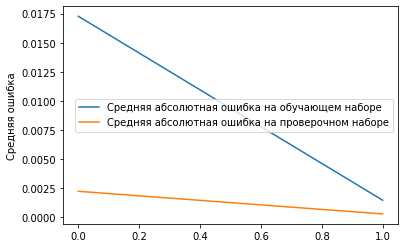

In [ ]:
#Создаём нейронку
modelD = Sequential()
modelD.add(Dense(150,input_shape = (xLen,5), activation="linear" )) # 5 - количество каналов
modelD.add(Flatten())
modelD.add(Dense(yTrain.shape[1], activation="linear"))

#Компилируем
modelD.compile(loss="mse", optimizer=Adam(lr=1e-4))

#Запускаем обучение
history = modelD.fit(
                    trainDataGen, 
                    epochs=2, 
                    verbose=1, 
                    validation_data = testDataGen 
                    )

#Выводим графики
plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
# Функция рассчитывает результаты прогнозирования сети
# В аргументы принимает сеть (currModel) и проверочную выборку
# Выдаёт результаты предсказания predVal
# И правильные ответы в исходной размерности yValUnscaled (какими они были до нормирования)
def getPred(currModel, xVal, yVal, yScaler):
  # Предсказываем ответ сети по проверочной выборке
  # И возвращаем исходны масштаб данных, до нормализации
  predVal = yScaler.inverse_transform(currModel.predict(xVal))
  yValUnscaled = yScaler.inverse_transform(yVal)
  
  return (predVal, yValUnscaled)

# Функция визуализирует графики, что предсказала сеть и какие были правильные ответы
# start - точка с которой начинаем отрисовку графика
# step - длина графика, которую отрисовываем
# channel - какой канал отрисовываем
def showPredict(start, step, channel, predVal, yValUnscaled):
  plt.plot(predVal[start:start+step, channel],
           label='Прогноз')
  plt.plot(yValUnscaled[start:start+step, channel], 
           label='Базовый ряд')
  plt.xlabel('Время')
  plt.ylabel('Значение Close')
  plt.legend()
  plt.show()
  
# Функция расчёта корреляции двух одномерных векторов
def correlate(a, b):
  # Рассчитываем основные показатели
  ma = a.mean() # Среднее значение первого вектора
  mb = b.mean() # Среднее значение второго вектора
  mab = (a*b).mean() # Среднее значение произведения векторов
  sa = a.std() # Среднеквадратичное отклонение первого вектора
  sb = b.std() # Среднеквадратичное отклонение второго вектора
  
  #Рассчитываем корреляцию
  val = 1
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val

# Функция рисует корреляцию прогнозированного сигнала с правильным
# Смещая на различное количество шагов назад
# Для проверки появления эффекта автокорреляции
# channels - по каким каналам отображать корреляцию
# corrSteps - на какое количество шагов смещать сигнал назад для расчёта корреляции
def showCorr(channels, corrSteps, predVal, yValUnscaled):
  # Проходим по всем каналам
  for ch in channels:
    corr = [] # Создаём пустой лист, в нём будут корреляции при смещении на i рагов обратно
    yLen = yValUnscaled.shape[0] # Запоминаем размер проверочной выборки

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      corr.append(correlate(yValUnscaled[:yLen-i,ch], predVal[i:, 0]))

    own_corr = [] # Создаём пустой лист, в нём будут корреляции при смещении на i шагов обратно

      # Постепенно увеличиваем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      own_corr.append(correlate(yValUnscaled[:yLen-i,ch], yValUnscaled[i:, ch]))

    # Отображаем график коррелций для данного шага
    plt.plot(corr, label='Предсказание на ' + str(ch+1) + ' шаг')
    plt.plot(own_corr, label='Эталон')

  plt.xlabel('Время')
  plt.ylabel('Значение')
  plt.legend()
  plt.show()

In [ ]:
#Создадим генератор проверочной выборки, из которой потом вытащим xVal, yVal для проверки
DataGen = TimeseriesGenerator(xTest, yTest,
                               length=xLen, sampling_rate=1,
                               batch_size=len(xTest)) #размер batch будет равен длине нашей выборки
xVal = []
yVal = []
for i in DataGen:
  xVal.append(i[0])
  yVal.append(i[1])

xVal = np.array(xVal)
yVal = np.array(yVal)

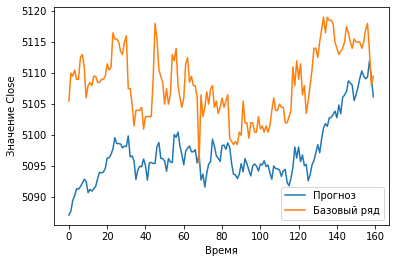

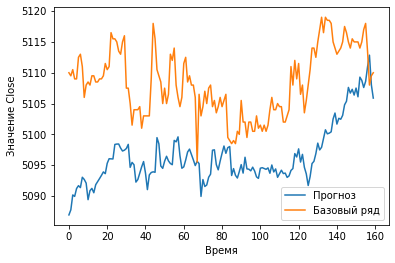

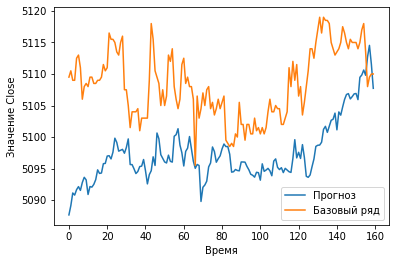

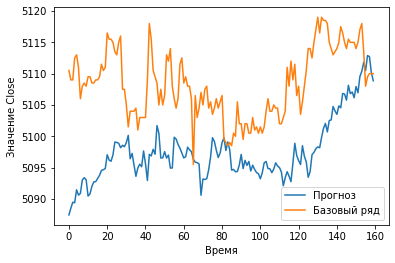

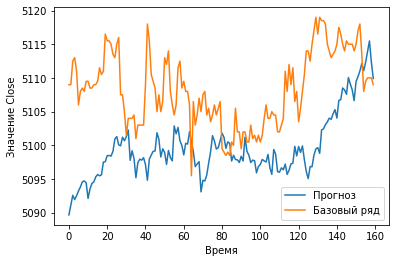

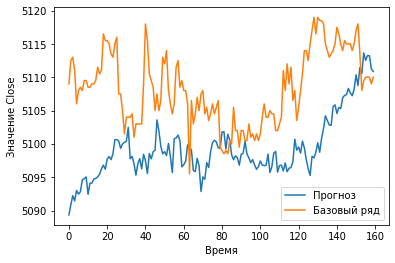

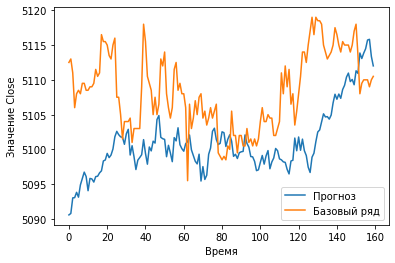

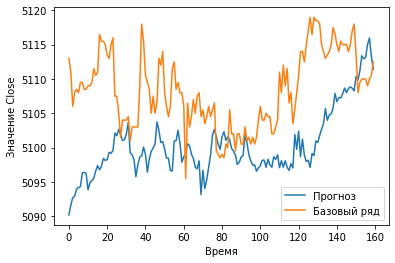

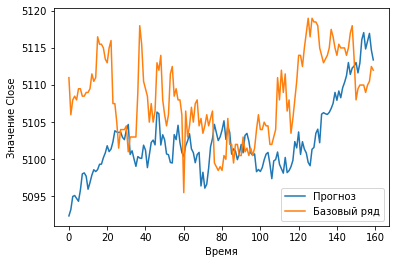

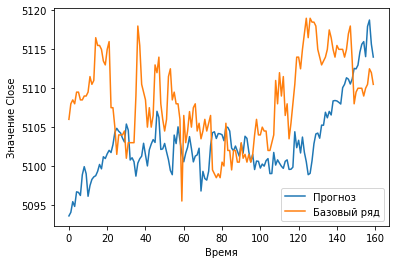

In [ ]:
#Прогнозируем данные текущей сетью
currModel = modelD #Выбираем текущую модель
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler) #Прогнозируем данные

#Отображаем графики
for i in range(10):
    showPredict(0, 160, i, predVal, yValUnscaled)


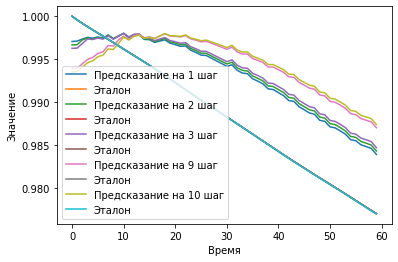

In [ ]:
#Отображаем корреляцию
#Используем выходной канал - только close
#Проверяем корреляцию на глубину 60 шагов
showCorr([0, 1, 2, 8, 9], 60, predVal, yValUnscaled)

In [ ]:
modelC = Sequential()

modelC.add(Conv1D(200, 5, input_shape = (xLen,5), activation="linear"))
modelC.add(Flatten())
modelC.add(Dense(100, activation="linear"))
modelC.add(Dense(yTrain.shape[1], activation="linear"))

modelC.compile(loss="mse", optimizer=Adam(lr=1e-4))
modelD.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 300, 150)          900       
_________________________________________________________________
flatten (Flatten)            (None, 45000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                450010    
Total params: 450,910
Trainable params: 450,910
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


22579/22579 [==============================] - 112s 4ms/step - loss: 0.1594 - val_loss: 0.0010
Epoch 2/20
22579/22579 [==============================] - 82s 4ms/step - loss: 0.0018 - val_loss: 8.3659e-04
Epoch 3/20
22579/22579 [==============================] - 82s 4ms/step - loss: 0.0021 - val_loss: 0.0186
Epoch 4/20
22579/22579 [==============================] - 82s 4ms/step - loss: 0.0012 - val_loss: 5.3335e-04
Epoch 5/20
22579/22579 [==============================] - 82s 4ms/step - loss: 0.0012 - val_loss: 7.8014e-04
Epoch 6/20
22579/22579 [==============================] - 82s 4ms/step - loss: 0.0011 - val_loss: 3.9660e-04
Epoch 7/20
22579/22579 [==============================] - 82s 4ms/step - loss: 0.0010 - val_loss: 1.8973e-04
Epoch 8/20
22579/22579 [==============================] - 82s 4ms/step - loss: 9.3412e-04 - val_loss: 2.3883e-04
Epoch 9/20
22579/22579 [==============================] - 82s 4ms/step - loss: 5.2136e-04 - val_loss: 1.6489e-04
Epoch 10/20
22579/22579 [====

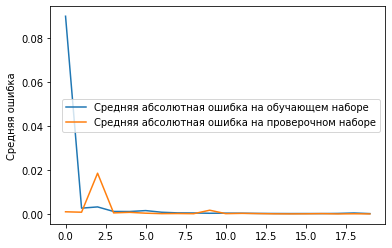

In [ ]:


history = modelC.fit_generator(trainDataGen,
                    epochs=20, 
                    verbose=1,
                    validation_data=testDataGen)

plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()



In [ ]:
#Прогнозируем данные текущей сетью
currModel = modelC
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler)

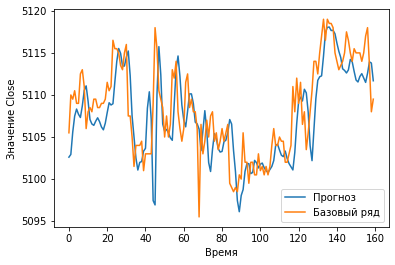

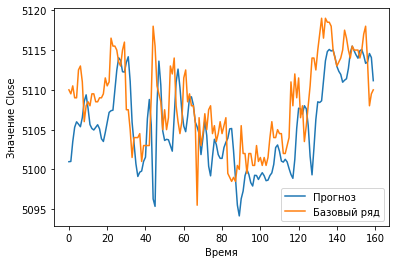

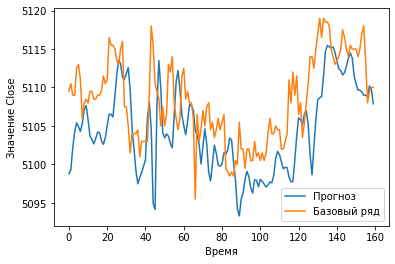

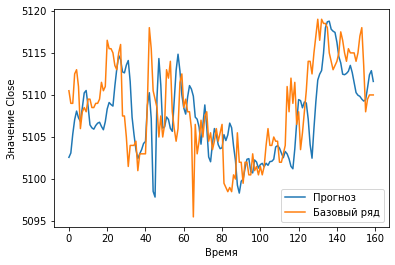

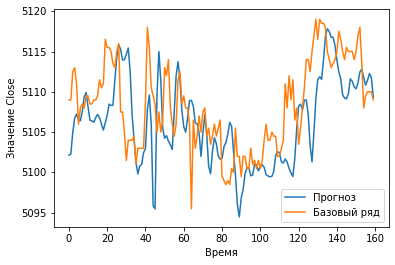

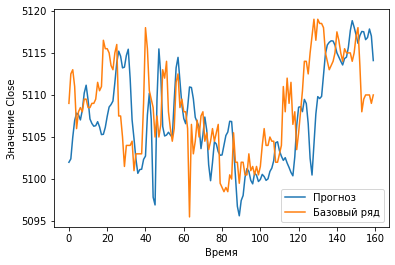

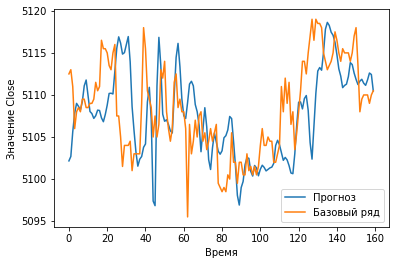

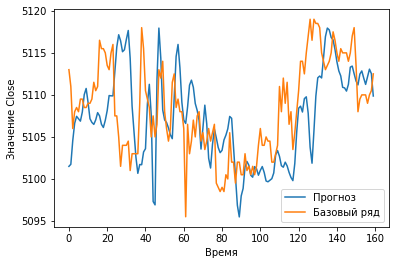

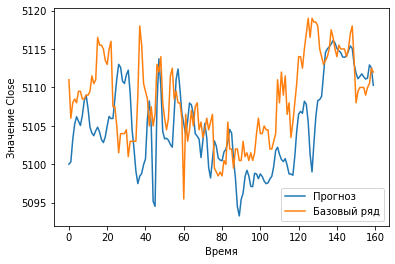

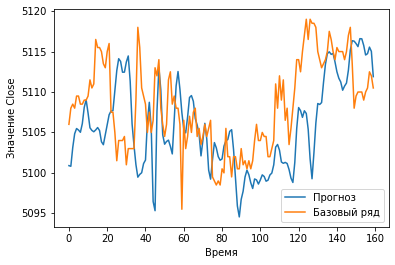

In [ ]:
for i in range(10):
    showPredict(0, 160, i, predVal, yValUnscaled)

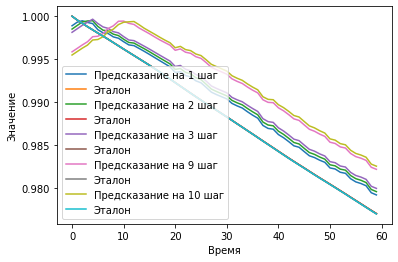

In [ ]:
#Отображаем корреляцию
showCorr([0, 1, 2, 8, 9], 60, predVal, yValUnscaled)